<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/Heatmap_each_Latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program generates one heatmap for each landmark, while `Heatmap_all.ipynb` generates one heatmap for all landmarks.

* 不要用 Gaussian 做 Label，匹配 Loss Function 的形状，保证理论上误差为0.


# 1. Initialize

In [1]:
# function ConnectButton(){
#   console.log("Connect pushed"); 
#   document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
# }
# setInterval(ConnectButton,60000);


# clearInterval(37042)

In [2]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['Procruses Analysis.ipynb',
 'PCA.ipynb',
 '__pycache__',
 'utils',
 'datasets',
 'Gaussian.ipynb',
 'Heatmap_all.ipynb',
 'trained_models',
 'DataPreprocessing.ipynb',
 'checkpoints',
 'Heatmap_each.ipynb',
 'Update_leaf.ipynb']

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import cv2
import json
import pandas as pd
from PIL import Image
import torchvision.models as models
import pdb
from torch.nn import Upsample
from torch.autograd import Variable
import torch.optim as optim
import time

import warnings
warnings.filterwarnings('ignore')


In [4]:
from utils.hourglass import *
from utils.dataloader import *

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dim_tree = 5 # how deep the regression tree is 
num_tree = 3 # number of regression trees
variance_gaussian = 3

num_fc = int(num_tree*(2**(dim_tree-1)-1))
num_leaf_nodes = int(num_tree*2**(dim_tree-1))

# 2. Data Loader

In [6]:
helen_trainset = Helen_set(dataset_type="train",var=variance_gaussian)

Loading [1/2000] pictures......
Loading [400/2000] pictures......
Loading [800/2000] pictures......
Loading [1200/2000] pictures......
Loading [1600/2000] pictures......
Loading [2000/2000] pictures......


In [7]:
#helen_testset = Helen_set(dataset_type="test",var=variance_gaussian)

In [8]:
train_dataloder = DataLoader(helen_trainset, batch_size=25)
#test_dataloder = DataLoader(helen_testset, batch_size=30)

# 3. Pre Train

In [9]:
# helen_sampleset = Helen_set(dataset_type="sample")
# sample_dataloder = DataLoader(helen_sampleset, batch_size=20)

In [10]:
# critical = torch.nn.MSELoss()

# nIters = 200
# HGNet = HGNet().to(device)
# optimizer = optim.SGD(HGNet.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [11]:
# loss_hist = torch.zeros(nIters)
# loss_epoch = torch.zeros(10)

# for iter in range(nIters):
#   for i, (x,_,y) in enumerate(sample_dataloder):
#     x = Variable(x,requires_grad=True).float().to(device)
#     y = Variable(y).float().to(device)
#     y_pred = HGNet.forward(x)
#     loss = critical(y_pred, y)
#     loss_epoch[i] = loss.item()

#     if i == 9:
#       loss_avg = torch.sum(loss_epoch)/10
#       loss_hist[iter] = loss_avg
#       if (iter+1)%10 == 0 or iter == 0:
#         print('Iter [%d/%d] loss %.4f' %(iter+1, nIters, loss_avg))
        
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

# plt.plot(torch.arange(nIters),loss_hist.detach().numpy())
# plt.title("Training Loss")

In [12]:
# torch.save(HGNet.state_dict(), "/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt")

# 4. Tune Training

## 4.1 Functions

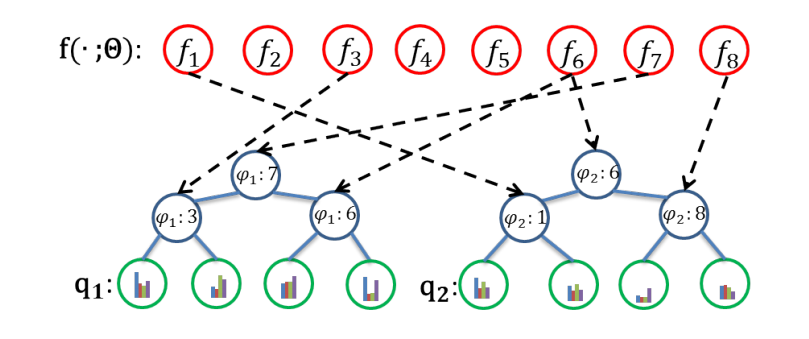

In [9]:
def leaf_direction(N):
  point = torch.zeros(2**N,N).to(device)

  def get01(number, len):
    result = torch.zeros(len).to(device)
    ind = len
    while ind >0:
      if 2**(ind-1)<=number:
        result[len-ind] = 1
        number -= 2**(ind-1)
      ind -= 1
    return result
  
  for i in range(2**N):
    point[i,:] = get01(i,N)

  return point.int()

In [10]:
def split_tree(up,here,which=0,mode='Second'):
  if mode=='initial':
    if which == 0:
      return here
    else: return (1-here)
  else:
    if which == 0:
      return up*here
    else: return up*(1-here)

In [11]:
def split_base(N):
  # returns index that split based on which cnn_fc col
  res = torch.zeros(2**N*N).to(device)
  lenth = 2**(N-1)
  num = 1
  left = 0
  repeat = 1
  max_repeat = 1
  while lenth>0 and repeat<2**N:
    res[left:left+lenth*2] = num
    left += lenth*2
    num += 1
    repeat -= 1
    if repeat == 0:
      lenth = int(lenth/2)
      repeat = max_repeat*2
      max_repeat = repeat
  return ((res.reshape(N,2**N)-1).T).int()

In [12]:
def phi(cnn_fc,mode='train'):
  N = cnn_fc.shape[0]
  out = torch.zeros(N,num_leaf_nodes).to(device)
  sigm = torch.zeros(cnn_fc.shape).to(device)

  if mode == 'test':
    sigm[cnn_fc>0] = 1
  else:
    sigm = torch.sigmoid(cnn_fc)

  direction = leaf_direction(dim_tree-1)
  tree_ind = split_base(dim_tree-1)
  X, Y = tree_ind.shape

  for ind_tree in range(num_tree):
    for x in range(X):
      for y in range(Y):
        here = sigm[:,ind_tree*(X-1)+tree_ind[x,y]]
        if y == 0:
          up = split_tree(torch.rand(3).to(device),here,which=direction[x,y],mode='initial')
        else:
          up = split_tree(up,here,which=direction[x,y])
        #print('y',y,'up',up)

      out[:,ind_tree*X+x] = up
    
  return out

In [13]:
def find_coord(prob_map):
  # prob_map(200,68*256*256)

  N = prob_map.shape[0]
  P = 12
  coord = torch.zeros(N,P*2).to(device)
  heatmap = prob_map.reshape(N,P,256,256).float()
  for n in range(N):
    for p in range(P):
      c1, c2 = torch.where(heatmap[n,p,:,:]==torch.max(heatmap[n,p,:,:]))
      coord[n,2*p], coord[n,2*p+1] = c1[0], c2[0]

  return coord

In [14]:
def get_mask(cnn_heatmaps,threshold=0.3):
  mask = torch.zeros(cnn_heatmaps.shape).to(device)
  B, P = cnn_heatmaps.shape[0:2]
  for b in range(B):
    for p in range(P):
      hm = cnn_heatmaps[b,p,:,:]
      mask[b,p,:,:][hm>torch.max(hm)*threshold]=1
  return mask

In [15]:
def update_iter(q, p, l):
  # q: leaf node
  # p: cnn probability
  # l: label

  gamma = torch.unsqueeze(p,2)*torch.unsqueeze(q,0) # (Ntrain,Nleaf,Nlabel)
  gamma = gamma/(torch.sum(gamma,axis=1,keepdims=True)+1e-8)
  score = torch.zeros(gamma.shape).to(q.device)
  for ll in range(q.shape[0]):
    score[:,ll,:] = l*gamma[:,ll,:]
  score = torch.sum(score,axis=0)+1e-8 # (3,2)

  return score/torch.sum(score,axis=1,keepdims=True)

In [16]:
def loss_ce(B, q, p, l):
  pred = torch.matmul(p,q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
  pred = pred/torch.sum(pred,axis=1,keepdims=True)
  l = l.reshape(B*12,-1)
  l = l/torch.sum(l,axis=1,keepdims=True)

  return -criterion_KL(l,pred)

def loss_l1(q, p, l):
  return torch.sum(torch.abs(torch.matmul(p,q)-l))/l.shape[0]

In [17]:
# def mask_and_norm(target, mask):
#   # target (B,12,256,256)
#   # mask (B,12,256,256)
#   B,P = target.shape[0:2]

#   res = (target*mask).reshape(B,P,-1)
#   res = res/torch.sum(res,axis=2,keepdims=True)
#   return res.reshape(B,-1)

## 4.2 Sample Set

In [22]:
# helen_sampleset = Helen_set(dataset_type="sample",var=variance_gaussian)
# sample_dataloder = DataLoader(helen_sampleset, batch_size=20)
# helen_sampletest = Helen_set(dataset_type="sample_test",var=variance_gaussian)
# sample_test_dataloder = DataLoader(helen_sampletest, batch_size=10)

## 4.3 Network

In [18]:
Tune_HGNet = HGNet(tune=True).to(device)
Tune_HGNet.load_state_dict(torch.load("/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt"))

<All keys matched successfully>

In [19]:
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(64,64,64)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(16,32,32)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2)).to(device)  #(4,16,16)

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*16*16,num_fc)).to(device)

## 4.4 Training

In [20]:
#######################
# Initialization
Total_train = 10

# CNN initilization
nIters = 200
learning_rate = 0.01

criterion_MSE = torch.nn.MSELoss()
criterion_KL = torch.nn.KLDivLoss()
optimizer = optim.SGD(Tune_HGNet.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

# Regression Tree parameters
rf_Iters = 60

### Training using L2 Loss

In [26]:
# Using L2 Loss

for round in range(Total_train):
  print("###########################################################")
  if torch.cuda.is_available():
    print("Round %d, Using GPU" %(round+1))
  else:
    print("Round ", round+1)
  
  #####################################
  ### Train Hourglass
  ### eyes: [36:48]
  #####################################
  if round == 0:
    leaf_q = torch.ones(num_leaf_nodes,12*256*256).to(device)/(256*256)
    cnn_Iters = 30
  else:
    cnn_Iters = nIters

  for iter in range(cnn_Iters):
    loss_epoch = 0
    for i, (x,_,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      x.requires_grad = True
      y = y.float().to(device)
      B = x.shape[0]

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)
      cnn_heatmaps = torch.matmul(cnn_prob,leaf_q).reshape(B,12,256,256)
      # get mask for computing cnn loss
      cnn_mask = get_mask(cnn_heatmaps,threshold=0.5)
      loss = criterion_MSE(cnn_heatmaps*cnn_mask, y[:,36:48,:,:]*cnn_mask)

      loss_epoch += loss.item()
      if (iter+1)%20 == 0 or iter == 0:
        if i == 9:
          print('     CNN training, Iter [%d/%d], loss_L2: %.8f' %(iter+1, cnn_Iters, loss_epoch*224*224*1e-1))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


  #####################################
  ### Train Regression Trees using pinv
  #####################################
  with torch.no_grad():
    leaf_q_new = torch.zeros(num_leaf_nodes,12*256*256).to(device)
    loss0 = 0

    for i, (x,coord,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      y = y.float().to(device)
      coord = coord.float().to(device)
      B = x.shape[0]
      y_expand = y[:,36:48,:,:].reshape(B,-1) #(200,12*256*256)

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)

      pred_coord0 = find_coord(torch.matmul(cnn_prob,leaf_q))
      loss0 += torch.sum(torch.abs(pred_coord0-coord[:,36:48,:].reshape(B,-1)))

      leaf_q_new += torch.matmul(torch.linalg.pinv(cnn_prob), y_expand) #(8,12*256*256)

    leaf_q = leaf_q_new/10  # average among each bach
    leaf_q = torch.abs(leaf_q.reshape(num_leaf_nodes,12,-1)) #(B,12,256*256)
    leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    for nleaf in range(num_leaf_nodes):
      for npoints in range(12):
        leaf_q[nleaf,npoints,:][leaf_q[nleaf,npoints,:] <= torch.max(leaf_q[nleaf,npoints,:])*0.2] = 0
    leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    leaf_q = leaf_q.reshape(num_leaf_nodes,-1)

    print("     RF training, coordinate loss: %.4f" %(loss0/10))





###########################################################
Round 1, Using GPU


NameError: ignored

### Training using Log likelihood

############################################################################
Round [1/10], Using GPU
     CNN training, Iter [1/30], loss_KL: 3.85498703
     CNN training, Iter [5/30], loss_KL: 3.85498703
     CNN training, Iter [10/30], loss_KL: 3.85498703
     CNN training, Iter [15/30], loss_KL: 3.85498703
     CNN training, Iter [20/30], loss_KL: 3.85498703
     CNN training, Iter [25/30], loss_KL: 3.85498703
     CNN training, Iter [30/30], loss_KL: 3.85498703
     -----> CNN training time: ## 32.19 mins ## 


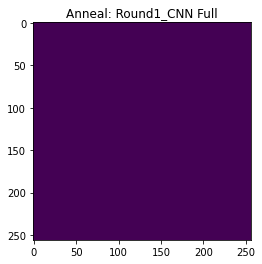

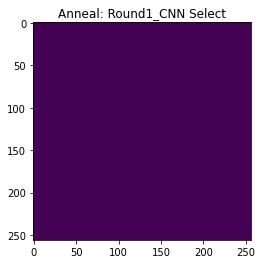

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.855604
     RF training, Batch 1, rf_iter [10/60], loss_KL: 3.855779
     RF training, Batch 1, rf_iter [20/60], loss_KL: 3.855819
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.855831
     RF training, Batch 1, rf_iter [40/60], loss_KL: 3.855836
     RF training, Batch 1, rf_iter [50/60], loss_KL: 3.855839
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.855840
     RF training, Batch 10, rf_iter [1/60], loss_KL: 3.855528
     RF training, Batch 10, rf_iter [10/60], loss_KL: 3.855692
     RF training, Batch 10, rf_iter [20/60], loss_KL: 3.855730
     RF training, Batch 10, rf_iter [30/60], loss_KL: 3.855740
     RF training, Batch 10, rf_iter [40/60], loss_KL: 3.855744
     RF training, Batch 10, rf_iter [50/60], loss_KL: 3.855746
     RF training, Batch 10, rf_iter [60/60], loss_KL: 3.855748
     RF training, Batch 20, rf_iter [1/60], loss_KL: 3.855579
     RF training, Batch 20, rf_iter [10/60], loss_KL: 3.855737
  

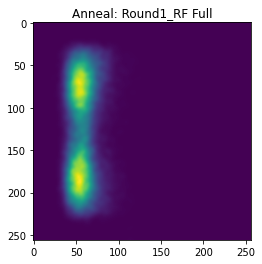

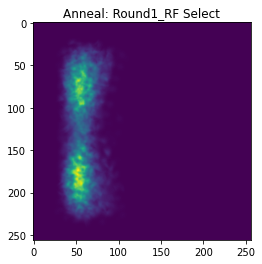

     -----> RF training time: ## 87.46 mins ## 
     -----> Training time for this round: ## 119.64 mins ## 
############################################################################
Round [2/10], Using GPU
     CNN training, Iter [1/200], loss_KL: 3.85525445
     CNN training, Iter [5/200], loss_KL: 3.85525440
     CNN training, Iter [10/200], loss_KL: 3.85525433
     CNN training, Iter [15/200], loss_KL: 3.85525431
     CNN training, Iter [20/200], loss_KL: 3.85525424
     CNN training, Iter [25/200], loss_KL: 3.85525418
     CNN training, Iter [30/200], loss_KL: 3.85525413
     CNN training, Iter [35/200], loss_KL: 3.85525406
     CNN training, Iter [40/200], loss_KL: 3.85525399
     CNN training, Iter [45/200], loss_KL: 3.85525394
     CNN training, Iter [50/200], loss_KL: 3.85525387
     CNN training, Iter [55/200], loss_KL: 3.85525378
     CNN training, Iter [60/200], loss_KL: 3.85525372
     CNN training, Iter [65/200], loss_KL: 3.85525370
     CNN training, Iter [70/200], lo

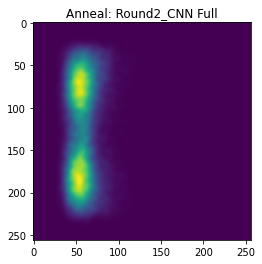

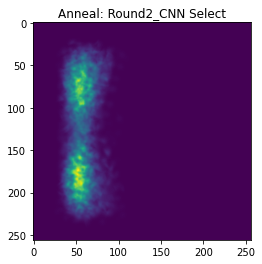

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.855612
     RF training, Batch 1, rf_iter [10/60], loss_KL: 3.855757
     RF training, Batch 1, rf_iter [20/60], loss_KL: 3.855789
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.855798
     RF training, Batch 1, rf_iter [40/60], loss_KL: 3.855802
     RF training, Batch 1, rf_iter [50/60], loss_KL: 3.855804
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.855805
     RF training, Batch 10, rf_iter [1/60], loss_KL: 3.855544
     RF training, Batch 10, rf_iter [10/60], loss_KL: 3.855674
     RF training, Batch 10, rf_iter [20/60], loss_KL: 3.855701
     RF training, Batch 10, rf_iter [30/60], loss_KL: 3.855708
     RF training, Batch 10, rf_iter [40/60], loss_KL: 3.855711
     RF training, Batch 10, rf_iter [50/60], loss_KL: 3.855713
     RF training, Batch 10, rf_iter [60/60], loss_KL: 3.855714
     RF training, Batch 20, rf_iter [1/60], loss_KL: 3.855588
     RF training, Batch 20, rf_iter [10/60], loss_KL: 3.855717
  

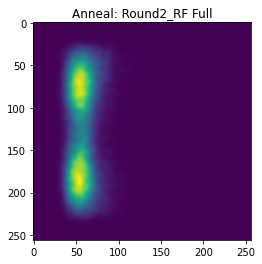

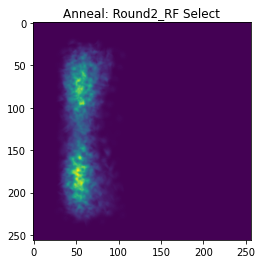

     -----> RF training time: ## 90.58 mins ## 
     -----> Training time for this round: ## 301.66 mins ## 
############################################################################
Round [3/10], Using GPU
     CNN training, Iter [1/200], loss_KL: 3.85525395
     CNN training, Iter [5/200], loss_KL: 3.85525392
     CNN training, Iter [10/200], loss_KL: 3.85525386
     CNN training, Iter [15/200], loss_KL: 3.85525379
     CNN training, Iter [20/200], loss_KL: 3.85525375
     CNN training, Iter [25/200], loss_KL: 3.85525368
     CNN training, Iter [30/200], loss_KL: 3.85525361
     CNN training, Iter [35/200], loss_KL: 3.85525357
     CNN training, Iter [40/200], loss_KL: 3.85525352
     CNN training, Iter [45/200], loss_KL: 3.85525347
     CNN training, Iter [50/200], loss_KL: 3.85525342
     CNN training, Iter [55/200], loss_KL: 3.85525336
     CNN training, Iter [60/200], loss_KL: 3.85525331
     CNN training, Iter [65/200], loss_KL: 3.85525324
     CNN training, Iter [70/200], lo

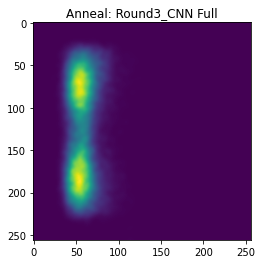

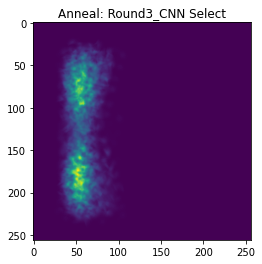

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.855603
     RF training, Batch 1, rf_iter [10/60], loss_KL: 3.855720
     RF training, Batch 1, rf_iter [20/60], loss_KL: 3.855750
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.855759
     RF training, Batch 1, rf_iter [40/60], loss_KL: 3.855763
     RF training, Batch 1, rf_iter [50/60], loss_KL: 3.855765
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.855766
     RF training, Batch 10, rf_iter [1/60], loss_KL: 3.855534
     RF training, Batch 10, rf_iter [10/60], loss_KL: 3.855640
     RF training, Batch 10, rf_iter [20/60], loss_KL: 3.855665
     RF training, Batch 10, rf_iter [30/60], loss_KL: 3.855673
     RF training, Batch 10, rf_iter [40/60], loss_KL: 3.855676
     RF training, Batch 10, rf_iter [50/60], loss_KL: 3.855677
     RF training, Batch 10, rf_iter [60/60], loss_KL: 3.855678
     RF training, Batch 20, rf_iter [1/60], loss_KL: 3.855579
     RF training, Batch 20, rf_iter [10/60], loss_KL: 3.855683
  

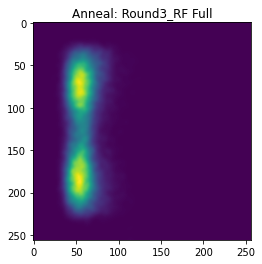

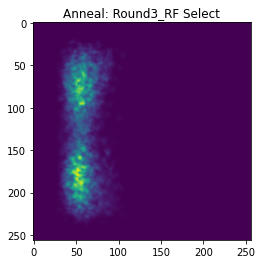

     -----> RF training time: ## 86.73 mins ## 
     -----> Training time for this round: ## 295.91 mins ## 
############################################################################
Round [4/10], Using GPU
     CNN training, Iter [1/200], loss_KL: 3.85525285
     CNN training, Iter [5/200], loss_KL: 3.85525281
     CNN training, Iter [10/200], loss_KL: 3.85525276
     CNN training, Iter [15/200], loss_KL: 3.85525272
     CNN training, Iter [20/200], loss_KL: 3.85525267
     CNN training, Iter [25/200], loss_KL: 3.85525261
     CNN training, Iter [30/200], loss_KL: 3.85525256
     CNN training, Iter [35/200], loss_KL: 3.85525250
     CNN training, Iter [40/200], loss_KL: 3.85525246
     CNN training, Iter [45/200], loss_KL: 3.85525240
     CNN training, Iter [50/200], loss_KL: 3.85525233
     CNN training, Iter [55/200], loss_KL: 3.85525230
     CNN training, Iter [60/200], loss_KL: 3.85525226
     CNN training, Iter [65/200], loss_KL: 3.85525220
     CNN training, Iter [70/200], lo

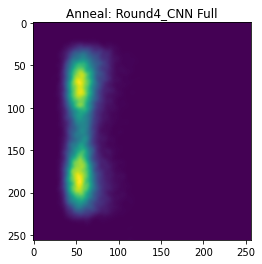

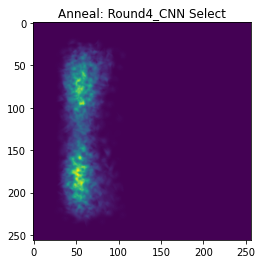

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.855593
     RF training, Batch 1, rf_iter [10/60], loss_KL: 3.855685
     RF training, Batch 1, rf_iter [20/60], loss_KL: 3.855713
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.855723
     RF training, Batch 1, rf_iter [40/60], loss_KL: 3.855727
     RF training, Batch 1, rf_iter [50/60], loss_KL: 3.855729
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.855730
     RF training, Batch 10, rf_iter [1/60], loss_KL: 3.855525
     RF training, Batch 10, rf_iter [10/60], loss_KL: 3.855607
     RF training, Batch 10, rf_iter [20/60], loss_KL: 3.855630
     RF training, Batch 10, rf_iter [30/60], loss_KL: 3.855639
     RF training, Batch 10, rf_iter [40/60], loss_KL: 3.855641
     RF training, Batch 10, rf_iter [50/60], loss_KL: 3.855643
     RF training, Batch 10, rf_iter [60/60], loss_KL: 3.855644
     RF training, Batch 20, rf_iter [1/60], loss_KL: 3.855571
     RF training, Batch 20, rf_iter [10/60], loss_KL: 3.855652
  

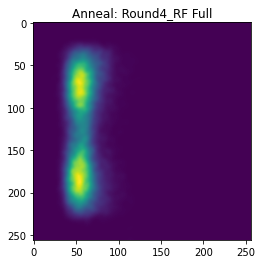

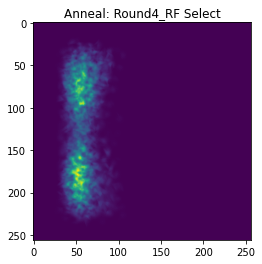

     -----> RF training time: ## 86.99 mins ## 
     -----> Training time for this round: ## 291.65 mins ## 
############################################################################
Round [5/10], Using GPU
     CNN training, Iter [1/200], loss_KL: 3.85525176
     CNN training, Iter [5/200], loss_KL: 3.85525173
     CNN training, Iter [10/200], loss_KL: 3.85525167
     CNN training, Iter [15/200], loss_KL: 3.85525165
     CNN training, Iter [20/200], loss_KL: 3.85525158
     CNN training, Iter [25/200], loss_KL: 3.85525153
     CNN training, Iter [30/200], loss_KL: 3.85525151
     CNN training, Iter [35/200], loss_KL: 3.85525146
     CNN training, Iter [40/200], loss_KL: 3.85525142
     CNN training, Iter [45/200], loss_KL: 3.85525136
     CNN training, Iter [50/200], loss_KL: 3.85525135
     CNN training, Iter [55/200], loss_KL: 3.85525130
     CNN training, Iter [60/200], loss_KL: 3.85525125
     CNN training, Iter [65/200], loss_KL: 3.85525119
     CNN training, Iter [70/200], lo

In [ ]:
# update using log likelihood

time_initial = time.time()
for round in range(Total_train):
  time_start = time.time()
  print("############################################################################")
  if torch.cuda.is_available():
    print("Round [%d/%d], Using GPU" %(round+1, Total_train))
  else:
    print("Round [%d/%d]" %(round+1, Total_train))

  
  ######################################################
  ### Train Hourglass
  ### eyes: [36:48]
  ######################################################
  if round == 0:
    leaf_q = torch.ones(num_leaf_nodes,12,256*256).to(device)/(256*256)
    cnn_Iters = 30
  else:
    cnn_Iters = nIters

  for iter in range(cnn_Iters):
    loss_epoch = 0
    for i, (x,_,y) in enumerate(train_dataloder):
      x = x.float().to(device)
      x.requires_grad = True
      y = y.float().to(device)
      B = x.shape[0]

      outputs = Tune_HGNet.forward(x)*(round*0.2+1)
      cnn_prob = phi(outputs)

      cnn_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
      cnn_heatmaps = cnn_heatmaps/torch.sum(cnn_heatmaps,axis=1,keepdims=True)
      label_heatmaps = y[:,36:48,:,:].reshape(B*12,-1)
      label_heatmaps = label_heatmaps/torch.sum(label_heatmaps,axis=1,keepdims=True)
      loss = -criterion_KL(cnn_heatmaps,label_heatmaps)

      loss_epoch += loss.item()
      if (iter+1)%5 == 0 or iter == 0:
        if i == 79:
          loss_epoch = loss_epoch/80
          print('     CNN training, Iter [%d/%d], loss_KL: %.8f' %(iter+1, cnn_Iters, loss_epoch*256*256))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  # calculate time for CNN training
  time_cnn = time.time()
  print("     -----> CNN training time: ## %.2f mins ## " %((time_cnn-time_start)/60))

  # plot the face after CNN training
  # Does not select
  cnn_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B,12,-1)
  first_face = torch.sum(cnn_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_CNN Full")
  plt.savefig(os.path.join("checkpoints/Anneal_Full_Train/var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_CNN_Full.png"))
  plt.show()

  # Selcet
  cnn_prob_test = phi(outputs, mode='test')
  cnn_heatmaps = torch.matmul(cnn_prob_test,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B,12,-1)
  first_face = torch.sum(cnn_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_CNN Select")
  plt.savefig(os.path.join("checkpoints/Anneal_Full_Train/var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_CNN_Select.png"))
  plt.show()

  ######################################################
  ### Train Regression Trees using variational bounding
  ######################################################
  with torch.no_grad():
    loss0 = 0
    leaf_q = leaf_q.reshape(num_leaf_nodes,12,256*256)
    new_leaf_q = torch.zeros(leaf_q.shape).to(device)

    for i, (x,coord,y) in enumerate(train_dataloder):
      next_leaf_q = leaf_q.clone()
      x = x.float().to(device)
      y = y.float().to(device)
      coord = coord.float().to(device)
      B = x.shape[0]
      y_expand = y[:,36:48,:,:].reshape(B,12,-1) #(200,12*256*256)

      outputs = Tune_HGNet.forward(x)*(round*0.2+1)
      cnn_prob = phi(outputs)

  
      for rf_iter in range(rf_Iters):
        for points_id in range(12):
          next_leaf_q[:,points_id,:] = update_iter(next_leaf_q[:,points_id,:], cnn_prob, y_expand[:,points_id,:])
        if ((i+1)%10 == 0 or i == 0) and ((rf_iter+1)%10 == 0 or rf_iter == 0):
          rf_loss_CE = loss_ce(B, next_leaf_q, cnn_prob, y_expand)
          print("     RF training, Batch %d, rf_iter [%d/%d], loss_KL: %.6f" %(i+1, rf_iter+1, rf_Iters, rf_loss_CE*256*256))


      pred_coord0 = find_coord(torch.matmul(cnn_prob,next_leaf_q.reshape(num_leaf_nodes,-1)))
      loss0 += torch.sum(torch.abs(pred_coord0-coord[:,36:48,:].reshape(B,-1)))/B
      new_leaf_q += next_leaf_q
    leaf_q = new_leaf_q/torch.sum(new_leaf_q, axis=2, keepdims=True)
    print("     RF training, coordinate loss: %.2f" %(loss0/80))


  # plot the face after rf training
  # Does not select
  rf_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B,12,-1)
  first_face = torch.sum(rf_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_RF Full")
  plt.savefig(os.path.join("checkpoints/Anneal_Full_Train/var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_RF_Full.png"))
  plt.show()

  # Select
  cnn_prob_test = phi(outputs, mode='test')
  rf_heatmaps = torch.matmul(cnn_prob_test,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B,12,-1)
  first_face = torch.sum(rf_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_RF Select")
  plt.savefig(os.path.join("checkpoints/Anneal_Full_Train/var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_RF_Select.png"))
  plt.show()

  # save parameters for this round
  torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/Anneal_Full_Train/Tune_HGNet_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+'.pt'))
  torch.save(leaf_q, os.path.join("checkpoints/Anneal_Full_Train/leaf_q_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+'.pt'))

  # calculate time for rf training
  time_rf = time.time()
  print("     -----> RF training time: ## %.2f mins ## " %((time_rf-time_cnn)/60))
  print("     -----> Training time for this round: ## %.2f mins ## " %((time_rf-time_start)/60))

# Finish Training
torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/Anneal_Full_Train/Tune_HGNet_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))
torch.save(leaf_q, os.path.join("checkpoints/Anneal_Full_Train/leaf_q_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))

# calculate total training time
time_end = time.time()
print("-----> Total training time: ## %.2f hrs ## " %((time_end-time_initial)/3600))

## 4.5 Test

### Restore from saved weights

In [ ]:
Tune_HGNet = HGNet(tune=True).to(device)
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(64,64,64)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(16,32,32)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2)).to(device)  #(4,16,16)

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*16*16,num_fc)).to(device)

Tune_HGNet.load_state_dict(torch.load(os.path.join("checkpoints/var_"+str(variance_gaussian),"Tune_HGNet_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt")))
leaf_q = torch.load(os.path.join("checkpoints/var_"+str(variance_gaussian),"leaf_q_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))

In [ ]:
import torchsummary
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
torchsummary.summary(Tune_HGNet, (3,256,256))
print('parameters_count:',count_parameters(Tune_HGNet))

### Test

In [ ]:
heatmap_loss, coord_loss = 0, 0
Tune_HGNet.eval()
criterion = torch.nn.MSELoss()

for i, (img,coord,hm) in enumerate(sample_test_dataloder):
  img = img.float().to(device)
  img.requires_grad = True
  coord = coord.float().to(device)
  hm = hm.float().to(device)
  B = img.shape[0]
  
  outputs = Tune_HGNet.forward(img)
  pred_heatmaps = torch.matmul(phi(outputs,mode='test'),leaf_q.reshape(num_leaf_nodes,-1)) #(15,12*256*256)
  pred_coords = find_coord(pred_heatmaps) #(15,12*2)

  heatmap_loss += criterion(pred_heatmaps, hm[:,36:48,:,:].reshape(B,-1))
  coord_loss += torch.sum(torch.abs(pred_coords-coord[:,36:48,:].reshape(B,-1)))

print("Heatmap loss %.8f, Coord loss %.4f" %(heatmap_loss/10, coord_loss/10))

In [ ]:
phi(outputs)[0:5,:]

In [ ]:
for ith in range(8):
  x = pred_coords[ith,::2].detach().cpu()
  y = pred_coords[ith,1::2].detach().cpu()
  plt.scatter(x,256-y,label="Prediction %d" %ith)

  plt.legend(loc='lower left')
  plt.xlim(0,256)
  plt.ylim(0,256)

In [ ]:
ith = 0

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 1

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 2

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 3

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 4

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 5

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 6

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 7

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
plot_heatmaps = pred_heatmaps.reshape(B,12,256,256).detach().cpu()
plot_heatmaps_all = torch.sum(plot_heatmaps,axis=1)
plt.imshow(plot_heatmaps_all[ith,:,:])

In [ ]:
# one point
plt.imshow(plot_heatmaps[ith,0,:,:])

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[0,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[1,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[2,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[3,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[4,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[5,0,:,:].detach().cpu())

In [ ]:
image = torch.sum(hm, axis=1).detach().cpu()
plt.imshow(image[ith,:,:])

In [ ]:
plt.imshow(img[ith,:,:,:].detach().cpu().permute(1,2,0).int())